Ticker: dltr


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Model Selection time: 127.72073316574097 seconds
Best F1 score: 0.5108225108225108
Best params: {'max_depth': 5, 'n_estimators': 200}
Test F1 score: 0.47058823529411764



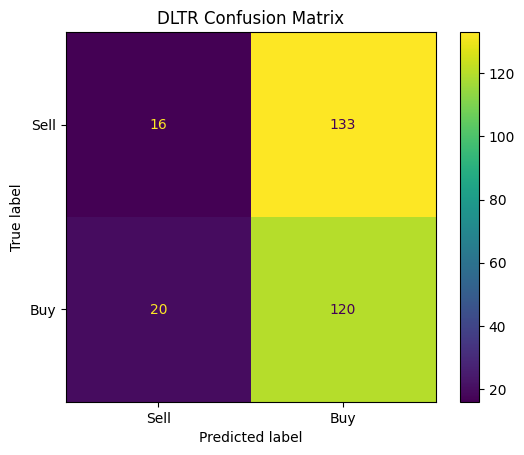

Ticker: lulu


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Model Selection time: 130.14606308937073 seconds
Best F1 score: 0.5220779220779221
Best params: {'max_depth': 5, 'n_estimators': 10}
Test F1 score: 0.48788927335640137



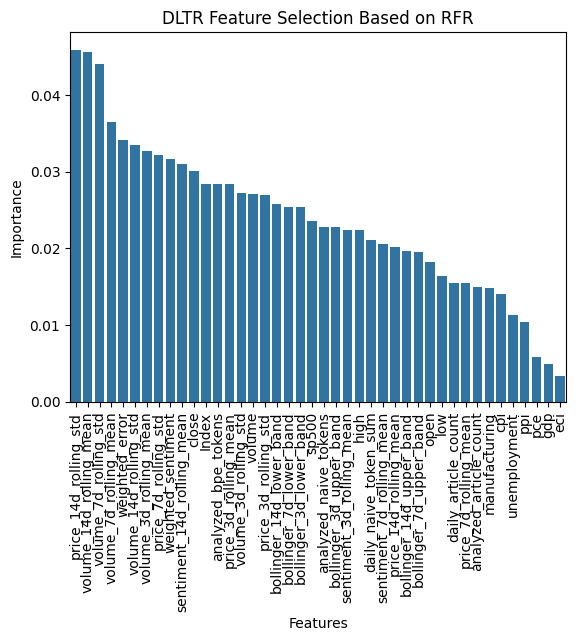

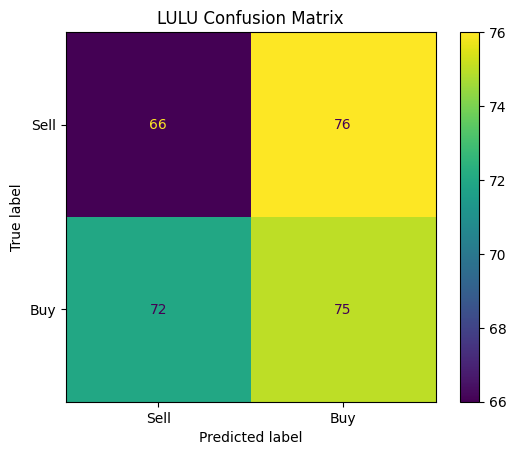

Ticker: ulta


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Model Selection time: 123.17781281471252 seconds
Best F1 score: 0.5134199134199133
Best params: {'max_depth': 5, 'n_estimators': 10}
Test F1 score: 0.5190311418685121



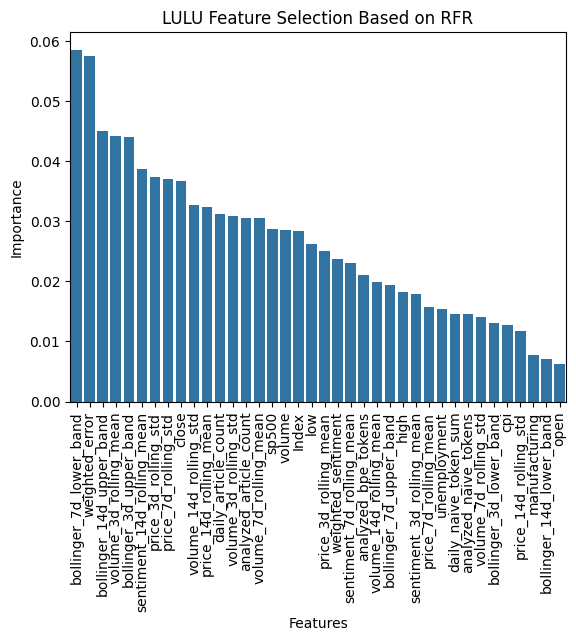

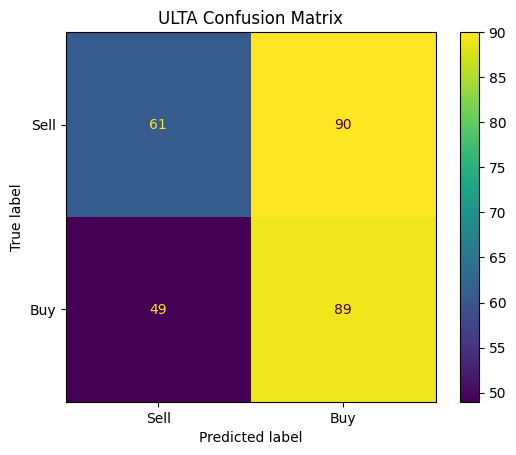

Ticker: wba


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Model Selection time: 126.63276028633118 seconds
Best F1 score: 0.49264069264069266
Best params: {'max_depth': 10, 'n_estimators': 50}
Test F1 score: 0.532871972318339



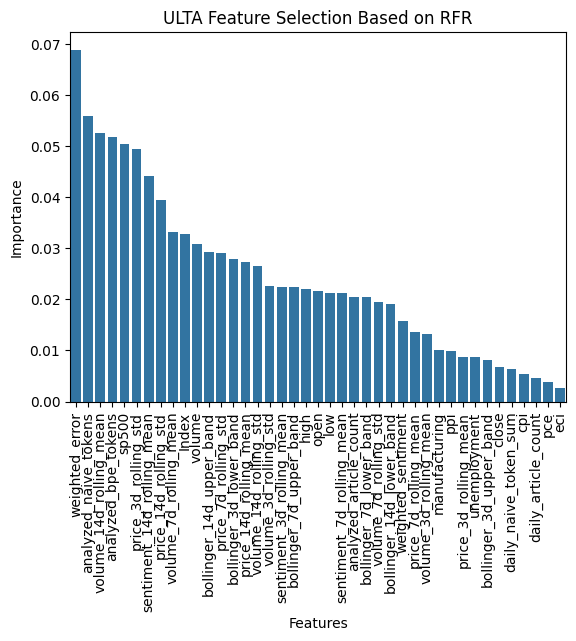

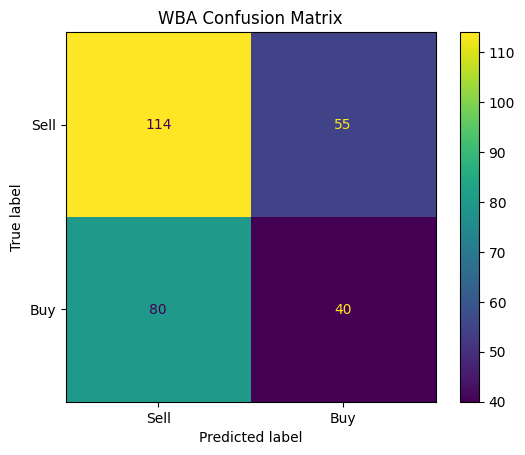

Ticker: wmt


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Model Selection time: 126.93426752090454 seconds
Best F1 score: 0.5160173160173159
Best params: {'max_depth': 20, 'n_estimators': 50}
Test F1 score: 0.49480968858131485



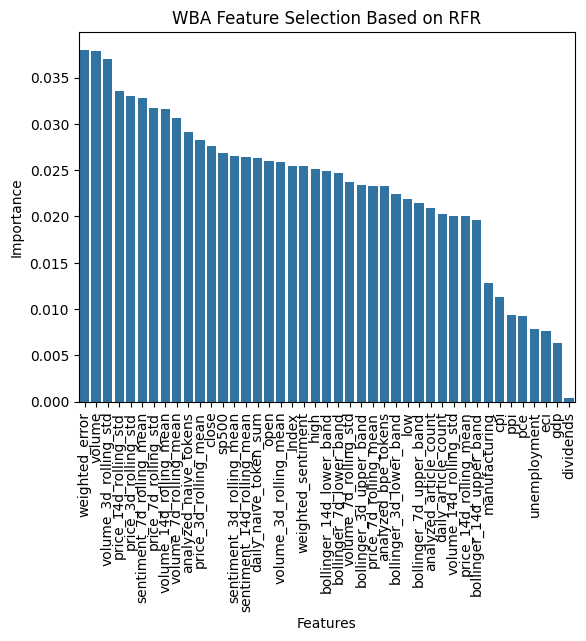

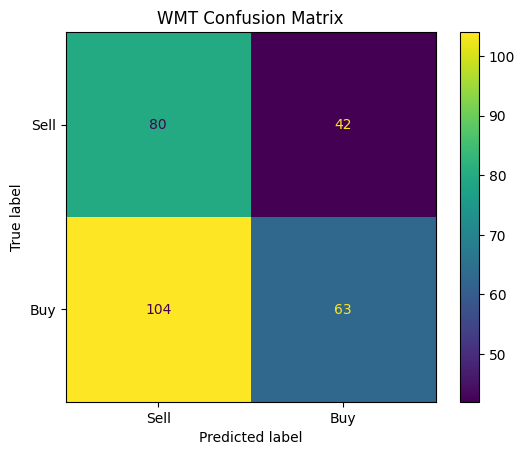

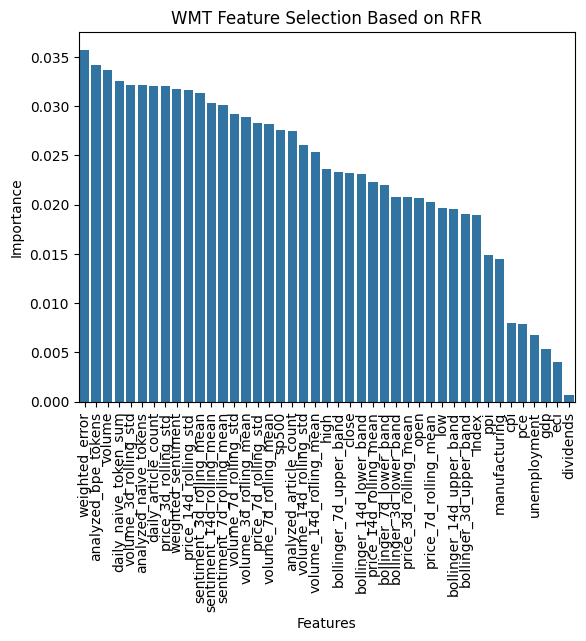

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow
import time

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV


TKRS = ["dltr", "lulu", "ulta", "wba", "wmt"]
for tkr in TKRS:
  print(f"Ticker: {tkr}")
  parquet_file = f"{tkr}_merged_data.parquet"
  df = pd.read_parquet(parquet_file)

  # Add Index as a column for ordinal encoding of days
  df.insert(0, 'Index', range(len(df)))

  #Drop Weekend rows
  df = df.dropna()

  #drop target columns for X
  X = df.drop(['target', 'target_price'], axis=1)

  # Label Target
  y = df['target']

  # Structured Train Test Split
  X_dev, X_test= np.split(X, [int(.8 *len(X))])
  y_dev, y_test= np.split(y, [int(.8 *len(y))])


  clf = RandomForestClassifier(random_state=42)

  # Hyper Parameter Tuning
  param_grid = {
  "n_estimators": [10, 50, 100, 200, 400],
  "max_depth" : [5, 10, 20, 30, 50],
  }

  start_time = time.time()
  model_grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='f1_micro')
  model_grid_search.fit(X_dev, y_dev)
  end_time = time.time()
  elapsed_time = end_time - start_time

  # Evaluate Model
  print(f"Model Selection time: {elapsed_time} seconds")
  print(f"Best F1 score:", model_grid_search.best_score_)
  print(f"Best params:", model_grid_search.best_params_)
  print(f"Test F1 score:", model_grid_search.score(X_test, y_test))
  print()

  tuned_model = model_grid_search.best_estimator_
  y_pred = tuned_model.predict(X_test)

  # [0, 1]
  class_names = ['Sell', 'Buy']

  # Confusion
  cm = metrics.confusion_matrix(y_test, y_pred)
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot()
  plt.title(f'{tkr.upper()} Confusion Matrix')
  plt.show()

  # Feature Importance
  feat_imps = zip(X_dev.columns, model_grid_search.best_estimator_.feature_importances_)
  feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x: x[1], reverse=True)))
  ax = sns.barplot(x=list(feats), y=list(imps))
  ax.set_title(f'{tkr.upper()} Feature Selection Based on RFR')
  ax.set_xlabel('Features')
  ax.set_ylabel('Importance')
  ax.tick_params(axis='x', rotation=90)
